# Outline

- Test to see whether PCLR representations and the extra tabular features can boost predictive performance with a linear model
- Try out: 
    - PCLR alone
    - PCLR + age, sex, creat, bnp
- For ease of comparison, filter for data that has all things available 

In [29]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

# Data loading

## Load in the main table

In [3]:
tab = '/storage/shared/apollo/same-day/tabular_data.csv'
df_tab = pd.read_csv(tab)
df_tab = df_tab.dropna(subset=['CO'])

## Load in creat and BNP tables

In [4]:
df_creat = pd.read_csv('../creat_processed.csv')
df_bnp = pd.read_csv('../bnp_processed.csv')

## Load in PCLR reprs

In [10]:
# NOTE: these have the same dimensionality/key mapping as df_tab
pclr_reprs = np.load('pclr.npy')

## Make a new set of idxs and df that contains labs within 2 wks before cath

A todo here is to extend this to store the LATEST lab result for all patient and also the time when it was obtained. 

In [711]:
TIMETHRESH = np.inf

In [712]:
df_creat_2wks = df_creat.loc[df_creat['Delta']<TIMETHRESH]
df_creat_2wks = df_creat_2wks.loc[df_creat_2wks['Delta']>=0]

In [713]:
df_bnp_2wks = df_bnp.loc[df_bnp['Delta']<TIMETHRESH]
df_bnp_2wks = df_bnp_2wks.loc[df_bnp_2wks['Delta']>=0]

In [714]:
df_creat_2wks

,idx,QuantaID,Date_of_Cath,Creatinine,CO,PCWP_mean,Delta
0,1,1398820,2016-08-19,4.18,4.10,26.0,0
1,1,1654372,2010-06-04,0.99,2.77,23.0,0
2,1,303155,2010-03-18,1.49,4.17,9.0,0
3,1,303155,2010-03-25,1.50,3.61,13.0,0
4,1,1092577,2011-07-12,0.91,7.73,19.0,0
...,...,...,...,...,...,...,...
6234,1,168424,2019-11-01,1.02,5.05,6.0,0
6235,1,562848,2020-02-13,0.99,5.30,18.0,0
6236,1,713398,2020-01-22,2.79,4.20,9.0,0
6237,1,884037,2020-01-23,0.67,3.00,9.0,0


In [715]:
df_bnp_2wks

,idx,QuantaID,Date_of_Cath,NTProBNP,CO,PCWP_mean,Delta
0,3,1398820,2016-08-19,7986.0,4.10,26.0,136
1,1,1654372,2010-06-04,17914.0,2.77,23.0,1
2,1,303155,2010-03-18,4376.0,4.17,9.0,0
3,1,303155,2010-03-25,8418.0,3.61,13.0,2
6,1,314037,2017-12-29,3773.0,2.70,14.0,4
...,...,...,...,...,...,...,...
5033,1,304392,2019-03-06,2830.0,4.13,35.0,3
5035,1,1261260,2019-03-27,4981.0,1.55,24.0,0
5036,2,168424,2019-09-30,3675.0,2.95,32.0,32
5037,2,168424,2019-10-17,3675.0,3.35,20.0,49


In [716]:
df_pclr_lookup = df_tab[['QuantaID', 'Date_of_Cath']]
df_pclr_lookup.insert(0, 'PCLR_index', list(range(len(df_pclr_lookup))))

In [717]:
df_final = df_tab.copy()
df_final['NTProBNP'] = np.nan
df_final['Creatinine'] = np.nan
df_final['NTProBNPDelta'] = np.nan
df_final['CreatinineDelta'] = np.nan
df_final['PCLR_index'] = list(range(len(df_pclr_lookup)))

In [718]:
# For each row in df_final, find the relevant creat and bnp value and store them if they are available
for i in df_final.index:
    apollo_row = df_final.loc[i]
    qid = apollo_row['QuantaID']
    co = apollo_row['CO']
    pcwp = apollo_row['PCWP_mean']
    doc = apollo_row['Date_of_Cath']
#     doc_proc = datetime.strptime(doc, '%Y-%m-%d')

    aux_df = df_bnp_2wks[df_bnp_2wks['QuantaID'] == qid]
    aux_df = aux_df[aux_df['Date_of_Cath'] == doc]
#     print(aux_df)
    if len(aux_df) > 0 :
#         print(aux_df)
        for j in aux_df.index:
            bnp_row = aux_df.loc[j]
            bnp_value = float(bnp_row['NTProBNP'])
            bnp_delta = float(bnp_row['Delta'])
            df_final.loc[i, 'NTProBNP'] = bnp_value
            df_final.loc[i, 'NTProBNPDelta'] = bnp_delta
            break

    aux_df = df_creat_2wks[df_creat_2wks['QuantaID'] == qid]
    aux_df = aux_df[aux_df['Date_of_Cath'] == doc]
#     print(aux_df)
    if len(aux_df) > 0 :
        for j in aux_df.index:
            creat_row = aux_df.loc[j]
            creat_value = float(creat_row['Creatinine'])
            creat_delta = float(creat_row['Delta'])
            df_final.loc[i, 'Creatinine'] = creat_value
            df_final.loc[i, 'CreatinineDelta'] = creat_delta
            break    
    

In [719]:
df_final_2wks = df_final.dropna(subset=['NTProBNP', 'Creatinine'])

In [720]:
len(df_final_2wks), len(df_final_2wks['QuantaID'].unique())

(4112, 2512)

## Prepare 2wk window data into feature arrays and preprocess

In [721]:
df_final_2wks.head()

,Unnamed: 0,QuantaID,Date_of_Cath,Age_at_Cath,Sex,PAP_sys,PAP_dia,PAP_mean,PCWP_sys,PCWP_dia,PCWP_mean,CO,PVR,Admit_Diag,NTProBNP,Creatinine,NTProBNPDelta,CreatinineDelta,PCLR_index
0,1,1398820,2016-08-19,80,True,53.0,31.0,38.0,29.0,33.0,26.0,4.10,2.926829,"['Acute ischemic heart disease, unspecified', ...",7986.0,4.18,136.0,0.0,0
1,4,1654372,2010-06-04,87,False,49.0,25.0,34.0,26.0,25.0,23.0,2.77,3.971119,['Acute systolic heart failure'],17914.0,0.99,1.0,0.0,1
2,8,303155,2010-03-18,86,True,26.0,9.0,14.0,NaN,15.0,9.0,4.17,1.199041,"['SEMI initial episode of care', 'CAD of vein ...",4376.0,1.49,0.0,0.0,2
3,9,303155,2010-03-25,86,True,29.0,8.0,17.0,NaN,15.0,13.0,3.61,1.108033,"['Atherosclerosis of Renal Artery', 'Aortic st...",8418.0,1.50,2.0,0.0,3
6,15,314037,2017-12-29,82,True,47.0,16.0,29.0,21.0,13.0,14.0,2.70,5.555556,['Chronic diastolic (congestive) heart failure'],3773.0,1.90,4.0,0.0,6


In [722]:
df_final_2wks['NTProBNPDelta'].min(), df_final_2wks['CreatinineDelta'].min()

(0.0, 0.0)

### Train/val/test split on patient ID level

In [723]:
uids = df_final_2wks['QuantaID'].unique()
frac_train = 0.8
frac_val = 0.2

fold = 0
test_start_idx = int(fold*0.2*len(uids))
test_end_idx = int((fold+1)*0.2*len(uids))

test_ids = uids[test_start_idx:test_end_idx]
train_val_ids = [i for i in uids if i not in test_ids]

TRAINVAL_END = int(1*len(train_val_ids))
train_val_ids = train_val_ids[:TRAINVAL_END]

train_ids = train_val_ids[:int(frac_train*len(train_val_ids))]
val_ids = train_val_ids[int(frac_train*len(train_val_ids)):]

train_df = df_final_2wks[df_final_2wks['QuantaID'].isin(train_ids)]
val_df = df_final_2wks[df_final_2wks['QuantaID'].isin(val_ids)]
test_df = df_final_2wks[df_final_2wks['QuantaID'].isin(test_ids)]

In [724]:
def make_feats(df_in):
    # Extract out the relevant features: age, sex, creat, bnp, pclr
    age = df_in['Age_at_Cath'].values
    sex = df_in['Sex'].astype(np.float32)
    creat = np.log(df_in['Creatinine'].values)
    bnp = np.log(df_in['NTProBNP'].values)
    creatdelta = np.log(df_in['CreatinineDelta'].values+1)
    bnpdelta = np.log(df_in['NTProBNPDelta'].values+1)
    pclr_idxs = df_in['PCLR_index'].values
    pclr_feats = pclr_reprs[pclr_idxs]
    demo_stack = np.stack([age, sex, creat, bnp, creatdelta, bnpdelta], axis=1)
    print(demo_stack.shape, pclr_feats.shape)
    return np.concatenate([demo_stack, pclr_feats], axis=1)

In [725]:
train_feats = make_feats(train_df)
val_feats = make_feats(val_df)
test_feats = make_feats(test_df)

(2846, 6) (2846, 320)
(624, 6) (624, 320)
(642, 6) (642, 320)


In [726]:
train_labels = train_df['PCWP_mean'] > 15
val_labels = val_df['PCWP_mean'] > 15
test_labels = test_df['PCWP_mean'] > 15

In [727]:
train_labels_mc = np.digitize(train_df['PCWP_mean'], [10, 15, 22])
val_labels_mc = np.digitize(val_df['PCWP_mean'], [10, 15, 22])
test_labels_mc = np.digitize(test_df['PCWP_mean'], [10, 15, 22])

### Normalization

In [728]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X=train_feats)
train_X = scaler.transform(train_feats)
val_X = scaler.transform(val_feats)
test_X = scaler.transform(test_feats)

(array([ 65., 147., 214., 539., 801., 594., 384.,  98.,   3.,   1.]),
 array([-2.96676033, -2.30141227, -1.63606422, -0.97071616, -0.30536811,
         0.35997995,  1.02532801,  1.69067606,  2.35602412,  3.02137217,
         3.68672023]),
 <a list of 10 Patch objects>)

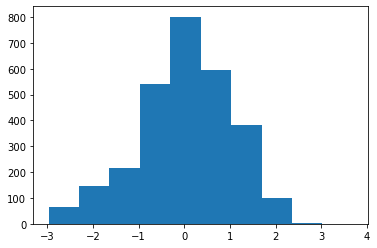

In [729]:
plt.hist(train_X[:,0])

(array([ 991.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1855.]),
 array([-1.36815446, -1.15824785, -0.94834124, -0.73843463, -0.52852802,
        -0.31862142, -0.10871481,  0.1011918 ,  0.31109841,  0.52100502,
         0.73091163]),
 <a list of 10 Patch objects>)

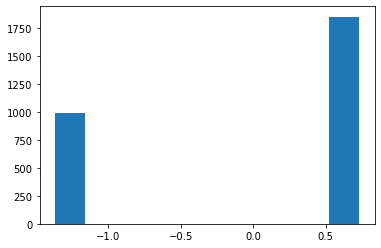

In [730]:
plt.hist(train_X[:,1])

(array([   2.,   15.,  231.,  812., 1035.,  454.,  186.,   64.,   31.,
          16.]),
 array([-3.58467843, -2.78014425, -1.97561007, -1.17107588, -0.3665417 ,
         0.43799248,  1.24252666,  2.04706084,  2.85159503,  3.65612921,
         4.46066339]),
 <a list of 10 Patch objects>)

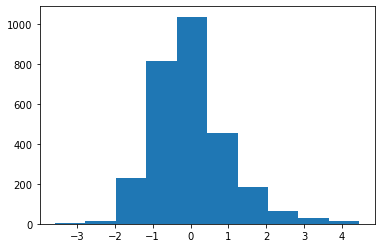

In [731]:
plt.hist(train_X[:,2])

(array([  5.,  21.,  68., 197., 524., 827., 776., 310., 108.,  10.]),
 array([-4.18121731, -3.44569976, -2.7101822 , -1.97466465, -1.23914709,
        -0.50362954,  0.23188802,  0.96740557,  1.70292313,  2.43844068,
         3.17395824]),
 <a list of 10 Patch objects>)

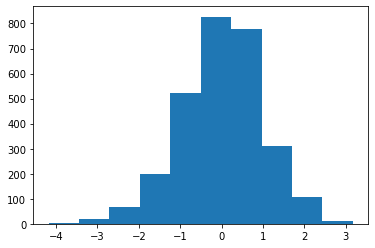

In [732]:
plt.hist(train_X[:,3])

(array([2.436e+03, 3.300e+01, 1.430e+02, 1.040e+02, 4.500e+01, 4.300e+01,
        2.100e+01, 1.400e+01, 5.000e+00, 2.000e+00]),
 array([-0.38407589,  0.30990709,  1.00389006,  1.69787304,  2.39185602,
         3.085839  ,  3.77982197,  4.47380495,  5.16778793,  5.8617709 ,
         6.55575388]),
 <a list of 10 Patch objects>)

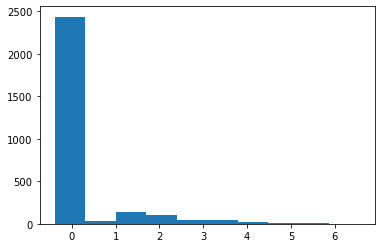

In [733]:
plt.hist(train_X[:,4])

(array([515., 273., 425., 247., 267., 362., 345., 260., 119.,  33.]),
 array([-1.5021033 , -1.11961312, -0.73712294, -0.35463276,  0.02785742,
         0.4103476 ,  0.79283778,  1.17532796,  1.55781814,  1.94030832,
         2.3227985 ]),
 <a list of 10 Patch objects>)

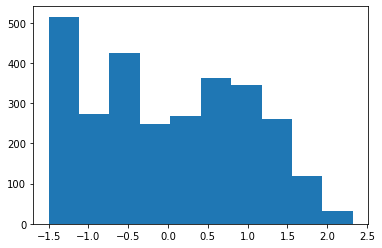

In [734]:
plt.hist(train_X[:,5])

# Train some models

In [735]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

### Start by fitting LR on only the ECG

In [736]:
train_ecg = train_X[:, 6:]
val_ecg = val_X[:, 6:]
test_ecg = test_X[:, 6:]
valperfs = []
testperfs = []
for C in [1e-5, 1e-4, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]:
    lr = LogisticRegression(C=C, max_iter=200)
    lr.fit(train_ecg, train_labels)
    val_probs = lr.predict_proba(val_ecg)[:,1]
    test_probs = lr.predict_proba(test_ecg)[:,1]
    valperfs.append(roc_auc_score(val_labels, val_probs))
    testperfs.append(roc_auc_score(test_labels, test_probs))

In [737]:
testperfs[np.argmax(valperfs)], np.max(valperfs)

(0.722956304619226, 0.8094445427022753)

### Then fit on only tabular

In [738]:
train_tab = train_X[:, :6]
val_tab = val_X[:, :6]
test_tab = test_X[:, :6]
valperfs = []
testperfs = []
for C in [1e-5, 1e-4, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]:
    lr = LogisticRegression(C=C, max_iter=200)
    lr.fit(train_tab, train_labels)
    val_probs = lr.predict_proba(val_tab)[:,1]
    test_probs = lr.predict_proba(test_tab)[:,1]
    valperfs.append(roc_auc_score(val_labels, val_probs))
    testperfs.append(roc_auc_score(test_labels, test_probs))

In [739]:
testperfs[np.argmax(valperfs)], np.max(valperfs)

(0.6899475655430712, 0.7340068040657934)

### Then fit on both

In [740]:
valperfs = []
testperfs = []
for C in [1e-5, 1e-4, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]:
    lr = LogisticRegression(C=C, max_iter=200)
    lr.fit(train_X, train_labels)
    val_probs = lr.predict_proba(val_X)[:,1]
    test_probs = lr.predict_proba(test_X)[:,1]
    valperfs.append(roc_auc_score(val_labels, val_probs))
    testperfs.append(roc_auc_score(test_labels, test_probs))

In [741]:
testperfs[np.argmax(valperfs)], np.max(valperfs)

(0.7391760299625468, 0.8046796158927996)

### Fit RF on only the ECG

In [742]:
from sklearn.ensemble import RandomForestClassifier

In [743]:
train_ecg = train_X[:, 6:]
val_ecg = val_X[:, 6:]
test_ecg = test_X[:, 6:]
valperfs = []
testperfs = []
for C in [10, 50, 100, 200, 1000]:
    lr = RandomForestClassifier(n_estimators=C, n_jobs=10)
    lr.fit(train_ecg, train_labels)
    val_probs = lr.predict_proba(val_ecg)[:,1]
    test_probs = lr.predict_proba(test_ecg)[:,1]
    valperfs.append(roc_auc_score(val_labels, val_probs))
    testperfs.append(roc_auc_score(test_labels, test_probs))

In [744]:
testperfs[np.argmax(valperfs)], np.max(valperfs)

(0.7350012484394507, 0.8080296299378895)

### Then fit on only tabular

In [745]:
train_tab = train_X[:, :6]
val_tab = val_X[:, :6]
test_tab = test_X[:, :6]
valperfs = []
testperfs = []
for C in [10, 50, 100, 200, 1000]:
    lr = RandomForestClassifier(n_estimators=C, n_jobs=10)
    lr.fit(train_tab, train_labels)
    val_probs = lr.predict_proba(val_tab)[:,1]
    test_probs = lr.predict_proba(test_tab)[:,1]
    valperfs.append(roc_auc_score(val_labels, val_probs))
    testperfs.append(roc_auc_score(test_labels, test_probs))

In [746]:
testperfs[np.argmax(valperfs)], np.max(valperfs)

(0.665378277153558, 0.7043768661763022)

### Then fit on both

In [747]:
valperfs = []
testperfs = []
for C in [10, 50, 100, 200, 1000]:
    lr = RandomForestClassifier(n_estimators=C, n_jobs=10)
    lr.fit(train_X, train_labels)
    val_probs = lr.predict_proba(val_X)[:,1]
    test_probs = lr.predict_proba(test_X)[:,1]
    valperfs.append(roc_auc_score(val_labels, val_probs))
    testperfs.append(roc_auc_score(test_labels, test_probs))

In [748]:
testperfs[np.argmax(valperfs)], np.max(valperfs)

(0.7340774032459425, 0.8074678263402657)

# Multiclass models

### Start by fitting LR on only the ECG

In [583]:
train_ecg = train_X[:, 6:]
val_ecg = val_X[:, 6:]
test_ecg = test_X[:, 6:]
valperfs = []
testperfs = []
for C in [1e-5, 1e-4, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]:
    lr = LogisticRegression(C=C, max_iter=500)
    lr.fit(train_ecg, train_labels_mc)
    val_probs = lr.predict_proba(val_ecg)
    test_probs = lr.predict_proba(test_ecg)
    valperfs.append(roc_auc_score(val_labels_mc, val_probs,average='macro', multi_class='ovo'))
    testperfs.append(roc_auc_score(test_labels_mc, test_probs,average='macro', multi_class='ovo'))

In [584]:
testperfs[np.argmax(valperfs)], np.max(valperfs)

(0.6330575771160266, 0.6745658547391914)

### Then fit on only tabular

In [585]:
train_tab = train_X[:, :6]
val_tab = val_X[:, :6]
test_tab = test_X[:, :6]
valperfs = []
testperfs = []
for C in [1e-5, 1e-4, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]:
    lr = LogisticRegression(C=C, max_iter=200)
    lr.fit(train_tab, train_labels_mc)
    val_probs = lr.predict_proba(val_tab)
    test_probs = lr.predict_proba(test_tab)
    valperfs.append(roc_auc_score(val_labels_mc, val_probs,average='macro', multi_class='ovo'))
    testperfs.append(roc_auc_score(test_labels_mc, test_probs,average='macro', multi_class='ovo'))

In [586]:
testperfs[np.argmax(valperfs)], np.max(valperfs)

(0.6180902801237111, 0.6497222099451543)

### Then fit on both

In [587]:
valperfs = []
testperfs = []
for C in [1e-5, 1e-4, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]:
    lr = LogisticRegression(C=C, max_iter=500)
    lr.fit(train_X, train_labels_mc)
    val_probs = lr.predict_proba(val_X)
    test_probs = lr.predict_proba(test_X)
    valperfs.append(roc_auc_score(val_labels_mc, val_probs,average='macro', multi_class='ovo'))
    testperfs.append(roc_auc_score(test_labels_mc, test_probs,average='macro', multi_class='ovo'))

In [588]:
testperfs[np.argmax(valperfs)], np.max(valperfs)

(0.6269746188213442, 0.6749676417819009)

### Fit RF on only the ECG

In [589]:
from sklearn.ensemble import RandomForestClassifier

In [590]:
train_ecg = train_X[:, 6:]
val_ecg = val_X[:, 6:]
test_ecg = test_X[:, 6:]
valperfs = []
testperfs = []
for C in [10, 50, 100, 200, 1000]:
    lr = RandomForestClassifier(n_estimators=C, n_jobs=10)
    lr.fit(train_ecg, train_labels_mc)
    val_probs = lr.predict_proba(val_ecg)
    test_probs = lr.predict_proba(test_ecg)
    valperfs.append(roc_auc_score(val_labels_mc, val_probs,average='macro', multi_class='ovo'))
    testperfs.append(roc_auc_score(test_labels_mc, test_probs,average='macro', multi_class='ovo'))

In [591]:
testperfs[np.argmax(valperfs)], np.max(valperfs)

(0.6471572877394475, 0.6769439005156368)

### Then fit on only tabular

In [592]:
train_tab = train_X[:, :6]
val_tab = val_X[:, :6]
test_tab = test_X[:, :6]
valperfs = []
testperfs = []
for C in [10, 50, 100, 200, 1000]:
    lr = RandomForestClassifier(n_estimators=C, n_jobs=10)
    lr.fit(train_tab, train_labels_mc)
    val_probs = lr.predict_proba(val_tab)
    test_probs = lr.predict_proba(test_tab)
    valperfs.append(roc_auc_score(val_labels_mc, val_probs,average='macro', multi_class='ovo'))
    testperfs.append(roc_auc_score(test_labels_mc, test_probs,average='macro', multi_class='ovo'))

In [593]:
testperfs[np.argmax(valperfs)], np.max(valperfs)

(0.5740295278915746, 0.638603930272332)

### Then fit on both

In [594]:
valperfs = []
testperfs = []
for C in [10, 50, 100, 200, 1000]:
    lr = RandomForestClassifier(n_estimators=C, n_jobs=10)
    lr.fit(train_X, train_labels_mc)
    val_probs = lr.predict_proba(val_X)
    test_probs = lr.predict_proba(test_X)
    valperfs.append(roc_auc_score(val_labels_mc, val_probs,average='macro', multi_class='ovo'))
    testperfs.append(roc_auc_score(test_labels_mc, test_probs,average='macro', multi_class='ovo'))

In [595]:
testperfs[np.argmax(valperfs)], np.max(valperfs)

(0.6500714778138368, 0.6868062773499037)